In [1]:
from random import randint, choice, random
import matplotlib.pyplot as plt
from functools import cmp_to_key

In [2]:
def tabuleiro(tamanho, quantidade):
  return [[randint(0,tamanho-1) for j in range(tamanho)] for i in range(quantidade)]

# tabuleiro(8,10)

In [3]:
def moveRainha(l,i):
  return [l[:i] + [k] + l[i+1:] for k in range(0,len(l)) if k != l[i]]

def todosVizinhos(T):
  vizinhos = []
  for i in range(len(T)):
    vizinhos.extend(moveRainha(T,i))
  return vizinhos

# todosVizinhos(tabuleiro(8,1)[0])

In [4]:
def umVizinho(T):
  return choice(todosVizinhos(T))

# tab = tabuleiro(8,1)[0]
# print(tab)
# print(umVizinho(tab))

In [5]:
def numeroAtaques(T):
  ataques = 0
  for i in range(len(T)):
    for j in range(i+1, len(T)):
      if(T[i] == T[j]): ataques += 1#; print(f'Rainha {i} ataca horizontalmente rainha {j}')
      if(abs(T[i] - T[j]) == abs(i - j)): ataques += 1#; print(f'Rainha {i} ataca diagonalmente rainha {j}')
  return ataques

# tab = tabuleiro(8,1)[0]
# print(tab)
# print(numeroAtaques(tab))

In [6]:
def gera_populacao(n):
  populacao = tabuleiro(tamanho_tabuleiro, n)
  return populacao

In [7]:
def adaptacao(cromossomo):
  maximo_ataques = tamanho_tabuleiro * (tamanho_tabuleiro - 1) / 2
  return (maximo_ataques - numeroAtaques(cromossomo)) / maximo_ataques

In [8]:
def roleta(populacao):
  soma = sum([adaptacao(cromossomo) for cromossomo in populacao])
  probabilidade = []
  for i in range(len(populacao)):
    probabilidade.append(adaptacao(populacao[i]) / soma)
    if i > 0:
      probabilidade[i] += probabilidade[i - 1]

  return probabilidade

In [9]:
def selecao(populacao):
  probabilidade = roleta(populacao)
  selecionados = []
  for i in range(len(populacao)):
    r = random()
    for j in range(len(probabilidade)):
      if r <= probabilidade[j]:
        selecionados.append(populacao[j])
        break
  return selecionados

In [10]:
def crossover(pai, mae):
  corte = randint(1, tamanho_tabuleiro - 1)
  filho1 = pai[:corte] + mae[corte:]
  filho2 = mae[:corte] + pai[corte:]
  return filho1, filho2

In [11]:
def mutacao(cromossomo):
  posicao = randint(0, tamanho_tabuleiro - 1)
  cromossomo = cromossomo[:posicao] + [randint(0, tamanho_tabuleiro - 1)] + cromossomo[posicao + 1:]
  return cromossomo

In [12]:
def seleciona_elite(populacao):
  populacao = sorted(populacao, key = adaptacao, reverse = True)
  return populacao[0]

In [13]:
def algoritmoGenetico(tamanho_populacao, n_geracoes, prob_crossover, prob_mutacao, elitismo = False):
  populacao = gera_populacao(tamanho_populacao) # Gera a população inicial
  melhores_individuos = []
  medias_adaptacao = []
  for i in range(n_geracoes):
    populacao_intermediaria = selecao(populacao) # Seleciona os indivíduos da população
    elite = seleciona_elite(populacao)

    medias_adaptacao.append(sum([adaptacao(cromossomo) for cromossomo in populacao_intermediaria]) / len(populacao_intermediaria))
    melhores_individuos.append(elite)
    #print(adaptacao(elite))
    #print(populacao)

    populacao = []
    for j in range(0, len(populacao_intermediaria) - 1, 2): # Realiza o crossover
      if random() < prob_crossover: 
        filho1, filho2 = crossover(populacao_intermediaria[j], populacao_intermediaria[j + 1])
        populacao.append(filho1)
        populacao.append(filho2)
      else:
        populacao.append(populacao_intermediaria[j])
        populacao.append(populacao_intermediaria[j + 1])
    
    if len(populacao_intermediaria) % 2 == 1: # Caso o número de indivíduos seja ímpar
      populacao.append(populacao_intermediaria[-1])

    for j in range(len(populacao)): # Realiza a mutação
      if random() < prob_mutacao:
        populacao[j] = mutacao(populacao[j])

    if elitismo: 
      populacao = populacao[:tamanho_populacao - 1] + [elite]


  
  return melhores_individuos, medias_adaptacao

In [14]:
def compare(x, y):
  if x['melhor'] > y['melhor']:
      return 1
  elif x['melhor'] < y['melhor']:
    return -1
  else:
    if x['media'] > y['media']:
      return 1
    elif x['media'] < y['media']:
      return -1
    else:
      return 0
    

In [15]:
def compara_hiperparametros(tamanho_populacao, n_geracoes, prob_crossover, prob_mutacao, elitismo = [True, False], n_repeticoes = 10):
  execucoes = []
  # populacao  * n_geracoes * 3 * 3 * 2 * 10 * (n_geracoes * populacao ** 2)
  for tamanho_populacao_atual in tamanho_populacao:# 500^3
    for n_geracoes_atual in n_geracoes: # 100^3
      for prob_mutacao_atual in prob_mutacao: # 3
        for prob_crossover_atual in prob_crossover: # 3
          for elitismo_atual in elitismo: # 2
            media = 0
            melhor = 0
            for i in range(n_repeticoes): # 10
              _, medias_adaptacao = algoritmoGenetico(tamanho_populacao_atual, n_geracoes_atual, prob_crossover_atual, prob_mutacao_atual, elitismo_atual)
              media += medias_adaptacao[-1]
              melhor = max(melhor, medias_adaptacao[-1])

            media /= n_repeticoes
            execucoes.append({
                'tamanho_populacao': tamanho_populacao_atual,
                'n_geracoes': n_geracoes_atual,
                'prob_crossover': prob_crossover_atual,
                'prob_mutacao': prob_mutacao_atual,
                'elitismo': elitismo_atual,
                'media': media,
                'melhor': melhor
            })
            
          comparacao = compare(execucoes[-1], execucoes[-2])
          if comparacao == 1:
            execucoes.pop(-2)
          elif comparacao == -1:
            execucoes.pop(-1)
          else:
            execucoes.pop(-2)
  
  execucoes = execucoes = sorted(execucoes, key=cmp_to_key(compare), reverse=True)
  return execucoes
    

In [16]:
tamanhos = [32]
for tamanho in tamanhos:
  tamanho_tabuleiro = tamanho
  execucoes = compara_hiperparametros(
    tamanho_populacao=[10, 100, 500],
    n_geracoes=[25, 50, 100],
    prob_crossover=[0.7, 0.75, 0.8],
    prob_mutacao=[0.01, 0.03, 0.05],
    elitismo = [True, False],
    n_repeticoes = 10)
  
  file = open('execucoes_' + str(tamanho) + '.txt', 'w')
  file.write(str(execucoes))
  file.close()

KeyboardInterrupt: 

In [680]:
execucoes

[{'tamanho_populacao': 100,
  'n_geracoes': 100,
  'prob_crossover': 0.8,
  'prob_mutacao': 0.01,
  'elitismo': True,
  'media': 0.957928571428571,
  'melhor': 1.0},
 {'tamanho_populacao': 100,
  'n_geracoes': 100,
  'prob_crossover': 0.75,
  'prob_mutacao': 0.01,
  'elitismo': True,
  'media': 0.9393928571428569,
  'melhor': 0.9860714285714286},
 {'tamanho_populacao': 100,
  'n_geracoes': 100,
  'prob_crossover': 0.7,
  'prob_mutacao': 0.03,
  'elitismo': True,
  'media': 0.948178571428571,
  'melhor': 0.984642857142857},
 {'tamanho_populacao': 100,
  'n_geracoes': 100,
  'prob_crossover': 0.7,
  'prob_mutacao': 0.01,
  'elitismo': True,
  'media': 0.9416071428571424,
  'melhor': 0.9835714285714288},
 {'tamanho_populacao': 500,
  'n_geracoes': 100,
  'prob_crossover': 0.7,
  'prob_mutacao': 0.01,
  'elitismo': True,
  'media': 0.9056000000000012,
  'melhor': 0.9782142857142869},
 {'tamanho_populacao': 10,
  'n_geracoes': 100,
  'prob_crossover': 0.75,
  'prob_mutacao': 0.03,
  'elitis

In [657]:
from functools import cmp_to_key
execucoes = sorted(execucoes, key=cmp_to_key(compare), reverse=True)

for execucao in execucoes:
  print(execucao)
  print()

{'tamanho_populacao': 50, 'n_geracoes': 1000, 'prob_crossover': 0.7, 'prob_mutacao': 0.01, 'elitismo': True, 'media': 0.9576190476190479, 'melhor': 1.0}

{'tamanho_populacao': 50, 'n_geracoes': 1000, 'prob_crossover': 0.7, 'prob_mutacao': 0.03, 'elitismo': True, 'media': 0.9700000000000001, 'melhor': 0.9892857142857144}

{'tamanho_populacao': 50, 'n_geracoes': 1000, 'prob_crossover': 0.8, 'prob_mutacao': 0.03, 'elitismo': True, 'media': 0.9669047619047619, 'melhor': 0.9828571428571429}

{'tamanho_populacao': 50, 'n_geracoes': 1000, 'prob_crossover': 0.7, 'prob_mutacao': 0.05, 'elitismo': True, 'media': 0.9480952380952384, 'melhor': 0.9778571428571429}

{'tamanho_populacao': 50, 'n_geracoes': 1000, 'prob_crossover': 0.75, 'prob_mutacao': 0.03, 'elitismo': True, 'media': 0.9330952380952383, 'melhor': 0.9728571428571431}

{'tamanho_populacao': 50, 'n_geracoes': 1000, 'prob_crossover': 0.7, 'prob_mutacao': 0.03, 'elitismo': False, 'media': 0.9330952380952383, 'melhor': 0.9685714285714286}


In [642]:
# Coloca um gráfico ao lado da outro
def imprime_resultados(execucao):
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  melhores_individuos, medias_adaptacao = execucao
  axs[0].plot(medias_adaptacao)
  axs[0].set_xlabel('Geração')
  axs[0].set_ylabel('Média de aptidão')
  axs[0].title.set_text('Média de aptidão por geração')


  axs[1].plot([adaptacao(individuo) for individuo in melhores_individuos])
  axs[1].set_xlabel('Geração')
  axs[1].set_ylabel('Aptidão melhor indivíduo')
  axs[1].title.set_text('Aptidão do melhor indivíduo por geração')

  plt.show()

  # Print do melhor indivíduo
  print('Melhor indivíduo: ', melhores_individuos[-1])
  print('Aptidão: ', adaptacao(melhores_individuos[-1]))

In [628]:
execucao = algoritmoGenetico(50, 1000, 0.7, 0.05, True)

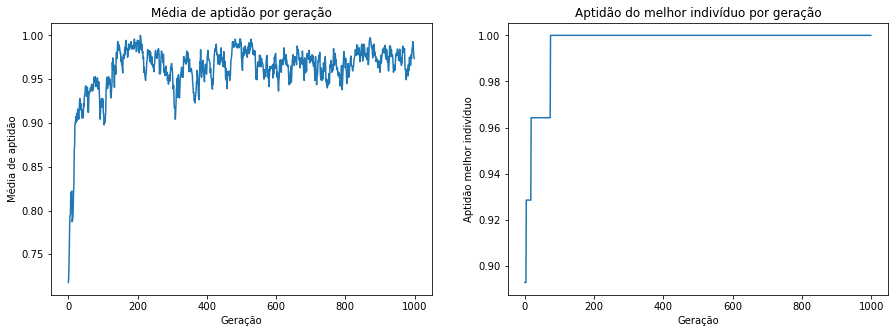

Melhor indivíduo:  [6, 3, 1, 7, 5, 0, 2, 4]
Aptidão:  1.0


In [643]:
imprime_resultados(execucao)